# **Predict TripAdvisor Rating**

# import

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import re
import datetime
from datetime import datetime


import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline


# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


# DATA

In [2]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [4]:
df_train.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [6]:
df_test.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [7]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [8]:
sample_submission.head()

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [9]:
#Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:

* City: Город
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com'
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

# Cleaning and Prepping Data

1. Обработка NAN

In [11]:
data.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating'],
      dtype='object')

In [12]:
data['ID']=data['ID_TA'].apply(lambda x:x[1:])
data['ID']

0        10746918
1         6674944
2        13129638
3          680417
4         1112354
           ...   
49995     2104414
49996     1800036
49997      947615
49998     1100838
49999     1109020
Name: ID, Length: 50000, dtype: object

In [13]:
data['URL_TA'].iloc[0]

'/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html'

In [14]:
data['info from url']=data['URL_TA'].apply(lambda x:x.split('-')[1][1:])
data['info from url']

0        187147
1        189934
2        186525
3        186338
4        274924
          ...  
49995    187849
49996    187147
49997    189852
49998    274856
49999    187849
Name: info from url, Length: 50000, dtype: object

In [15]:
#Рассмотрим наличие пропусков в таких колонках, как Cuisine Style, Price Range, Number of Reviews, Reviews
#У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью.По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак
data['Price Range_NaN']=pd.isna(data['Price Range']).astype('uint8')

In [16]:
#Рассмотрим наличие пропусков в таких колонках, как Cuisine Style, Price Range, Number of Reviews, Reviews
#У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью.По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак
data['Number of Reviews_NaN']=pd.isna(data['Number of Reviews']).astype('uint8')

In [17]:
data['Number of Reviews_NaN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number of Reviews_NaN, Length: 50000, dtype: uint8

In [18]:
data['Number of Reviews_NaN'].value_counts()

0    46800
1     3200
Name: Number of Reviews_NaN, dtype: int64

In [19]:
#Заменим пропуски на среднее значение столбца
data['Number of Reviews']=data['Number of Reviews'].fillna(data['Number of Reviews'].mean())

In [20]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [21]:
#Далее нам предстоит обработать категориальные признаки. Для начала рассмотрим колонку Price Range
#Избавимся от пропусков и заменим данные на числовые показатели,преждевременно создав словарь с числами, соответствующими каждому признаку($$-$$$,$$$$,$)
price_range={'$':1,
            '$$ - $$$':2,
            '$$$$':3}
#Избавимся от пропусков в колонке:
data['Price Range_NaN']=pd.isna(data['Price Range']).astype('uint8')
maxindex=0
for index,i in enumerate(data['Price Range'].value_counts()):
    if i == data['Price Range'].value_counts().max():
        maxindex=data['Price Range'].value_counts().index[index]
#print(maxindex)
data['Price Range']=data['Price Range'].fillna(maxindex)

In [22]:
for index,i in enumerate(data['Price Range']):
    data['Price Range'][index]=price_range[i]
data['Price Range']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0        2
1        2
2        2
3        3
4        3
        ..
49995    2
49996    2
49997    2
49998    2
49999    2
Name: Price Range, Length: 50000, dtype: object

In [23]:
#Рассмотрим колонку Cuisine Style
kitchen_count=[]# количество кухонь в каждом ресторане
kitchen=[]
for i in data['Cuisine Style'].fillna('lol'):
    l =i[1:-1].replace("'",'').split(', ')
    kitchen_count.append(len(l))
    for inf in l:
        kitchen.append(inf)
maxcount=max(Counter(kitchen),key=Counter(kitchen).get)#Находим часто встречающуюся кухню
print(len(kitchen_count))

50000


In [24]:
#Заменяем пропуски на  часто встречающуюся кухню
data['Cuisine Style_NaN']=pd.isna(data['Cuisine Style']).astype('uint8')
for index,info in enumerate(data['Cuisine Style'].isnull()):
    if info==True:
        data['Cuisine Style'].iloc[index]=maxcount

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [25]:
#Добавим колонку с количеством кухонь в ресторане
data['Count of Cuisine Style']=kitchen_count

In [26]:
for i in Counter(kitchen).keys():
    if i in data.columns:
        continue
    else:
        data[i]=0

In [27]:
# Рассмотрим колонку Reviews
data['Reviews'].isna().value_counts()

False    49998
True         2
Name: Reviews, dtype: int64

In [28]:
data['Reviews'].iloc[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

In [29]:
date=[]
date_count=[]
for a in data['Reviews']:
    date.append(re.findall('\d{2}/\d{2}/\d{4}',str(a)))
for inf in date:
        for index,i in enumerate(inf):
            inf[index]=datetime.strptime(i, "%m/%d/%Y")
for il in date:
    if len(il)==2:
        delta=max(il)-min(il)
        date_count.append(delta.days)
    else:
        date_count.append(0)
max(date_count)

3296

In [30]:
#Добавим колонку с разницей в днях между двумя комментариями
data['Date_Count']=date_count

In [31]:
#Добавим колонку с разницей в днях между сегодняшним днем и последним комментарием
date_today=[]
for i in date:
    if len(i)==0:
        date_today.append(0)
    elif len(i)==1:
        date_today.append((datetime.today()-i[0]).days)
    else:
        date_today.append((datetime.today()-max(i)).days)
len(date_today)
data['Date_Count_Today']=date_today

In [32]:
from sklearn.preprocessing import PolynomialFeatures
data=pd.merge(data, pd.get_dummies(data.City), left_index=True, right_index=True)

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 176 entries, Restaurant_id to Zurich
dtypes: float64(3), int64(130), object(9), uint8(34)
memory usage: 55.8+ MB


In [34]:
data

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,0,0,0,1,0,0,0,0,0,0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,2,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,...,0,0,0,0,0,0,0,0,0,0
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,2,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,...,0,0,0,1,0,0,0,0,0,0
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,2,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,...,0,0,0,0,0,0,1,0,0,0
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,2,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,...,0,0,0,0,0,0,0,0,1,0


# EDA

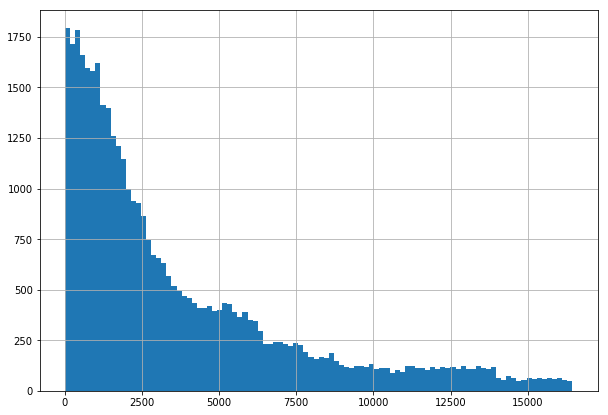

In [35]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

Большая часть ресторанов не дотягивают до 2500 места в рейтинге.Далее рассмотрим города


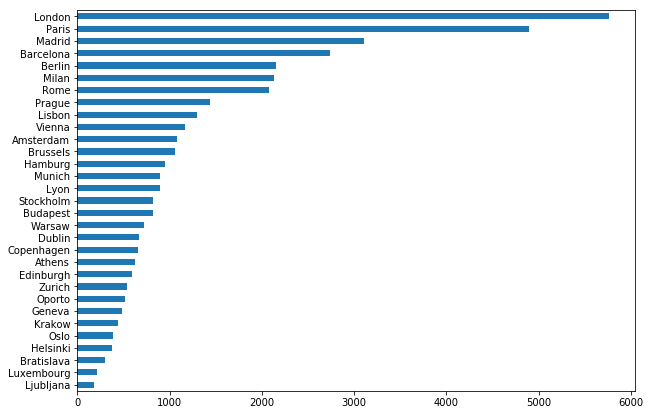

In [36]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

In [37]:
#Добавим колонку с информацией о столицах
list_NotCapitalCity = ['Barcelona', 'Milan', 'Hamburg', 'Munich', 
                          'Lyon', 'Zurich', 'Oporto', 'Geneva', 'Krakow']
data['Capital_City'] = data['City'].apply(lambda x: 0 if x in list_NotCapitalCity else 1)

In [38]:
#Также можно добавить информацию о странах 
dict_Сountries = {'London' : 'England', 'Paris' : 'France', 'Madrid' : 'Spain', 
                  'Barcelona' : 'Spain', 'Berlin' : 'Germany', 'Milan' : 'Italy', 
                  'Rome' : 'Italy', 'Prague' : 'Czech_c', 'Lisbon' : 'Portugal', 
                  'Vienna' : 'Austria', 'Amsterdam' : 'Holland', 
                  'Brussels' : 'Belgium', 'Hamburg' : 'Germany', 'Munich' : 'Germany', 
                  'Lyon' : 'France', 'Stockholm' : 'Sweden', 'Budapest' : 'Romania', 
                  'Warsaw' : 'Poland', 'Dublin' : 'Ireland', 'Copenhagen' : 'Denmark', 
                  'Athens' : 'Greece', 'Edinburgh' : 'Scotland', 'Zurich' : 'Switzerland', 
                  'Oporto' : 'Portugal', 'Geneva' : 'Switzerland', 'Krakow' : 'Poland', 
                  'Oslo' : 'Norway', 'Helsinki' : 'Finland', 'Bratislava' : 'Slovakia', 
                  'Luxembourg' : 'Luxembourg_c', 'Ljubljana' : 'Slovenia'}
data['Сountry'] = data.apply(lambda row: dict_Сountries[row['City']], axis = 1)

lb = LabelEncoder()
lb.fit(data['Сountry'])
data['code_Сountry'] = lb.transform(data['Сountry'])

In [39]:
#Плюс ко всему следует учесть население городов
City_population={'London':8908081,
                'Paris':2148327,
                'Madrid':3266126,
                'Barcelona':1636762,
                'Berlin':3644826,
                 'Milan':1366180,
                 'Rome':2870500, 
                 'Prague':1324277,
                 'Lisbon':506654,
                 'Vienna':1897491,
                 'Amsterdam':860124,
                 'Brussels':185103,
                 'Hamburg':1841179,
                 'Munich':1571508,
                 'Lyon':516092,   
                 'Stockholm':975904,
                 'Budapest':1752286,
                 'Warsaw':1790658,
                 'Dublin':1173179,
                 'Copenhagen':794128,
                 'Athens':664046,  
                 'Edinburgh':513210,
                 'Zurich':434008, 
                 'Oporto':237591,  
                 'Geneva':201818,  
                 'Krakow':779115,  
                 'Oslo':693494,    
                 'Helsinki':643272,
                 'Bratislava':437725,
                 'Luxembourg':626108,
                 'Ljubljana':284355}

In [40]:
CP=[]
for i in data['City']:
    CP.append(City_population[i])
data['City_Population']=CP

Можно заметить, что превосходство по количеству ресторанов у Европы. Далее рассмотрим распределиние рэйтинга в городе с наибольшим количеством ресторанов(London)

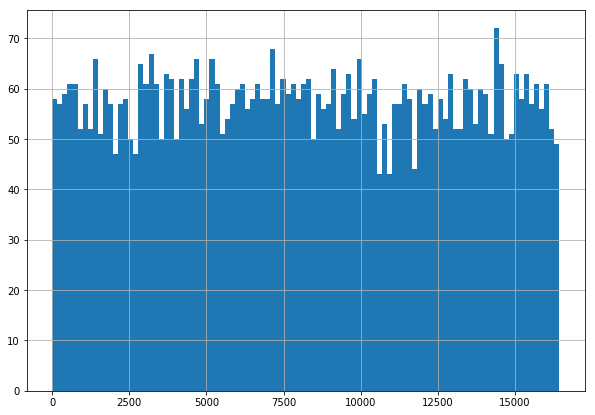

In [41]:
df_train['Ranking'][df_train['City']=='London'].hist(bins=100)

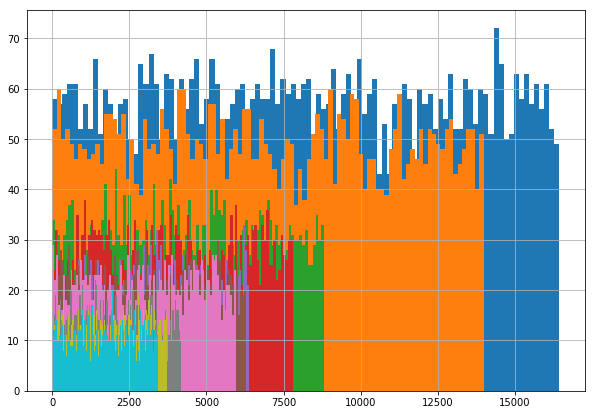

In [42]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Распределение целевой переменной

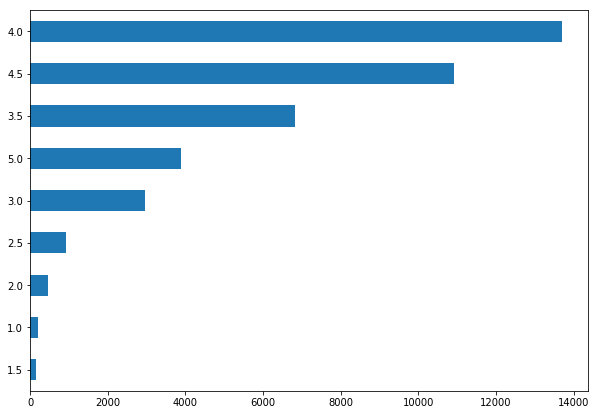

In [43]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

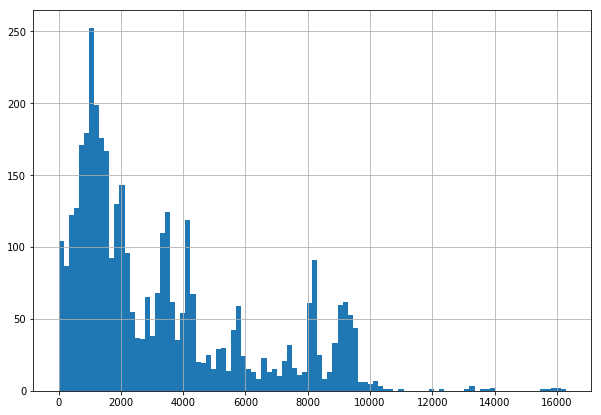

In [44]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

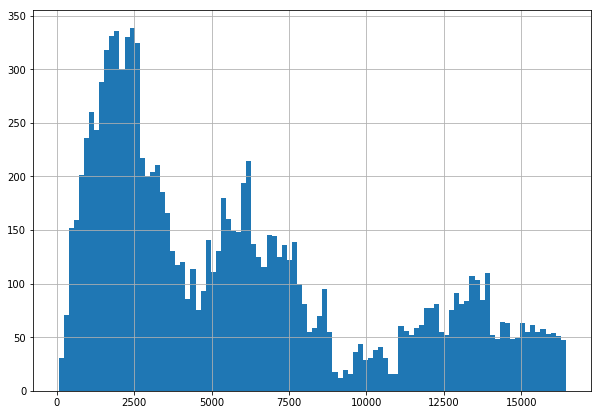

In [45]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

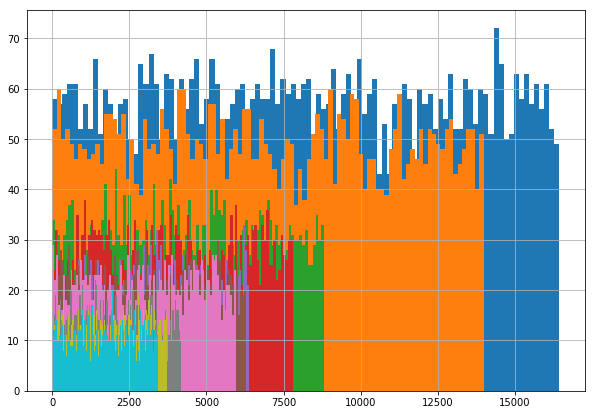

In [46]:
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

In [47]:
mean_Ranking_on_City = data.groupby(['City'])['Ranking'].mean()
count_Restorant_in_City = data['City'].value_counts(ascending=False)
data['mean_Ranking_on_City'] = data['City'].apply(lambda x: mean_Ranking_on_City[x])
data['count_Restorant_in_City'] = data['City'].apply(lambda x: count_Restorant_in_City[x])
data['norm_Ranking_on_Rest_in_City'] = (data['Ranking'] - data['mean_Ranking_on_City']) / data['count_Restorant_in_City']

Корреляция признаков

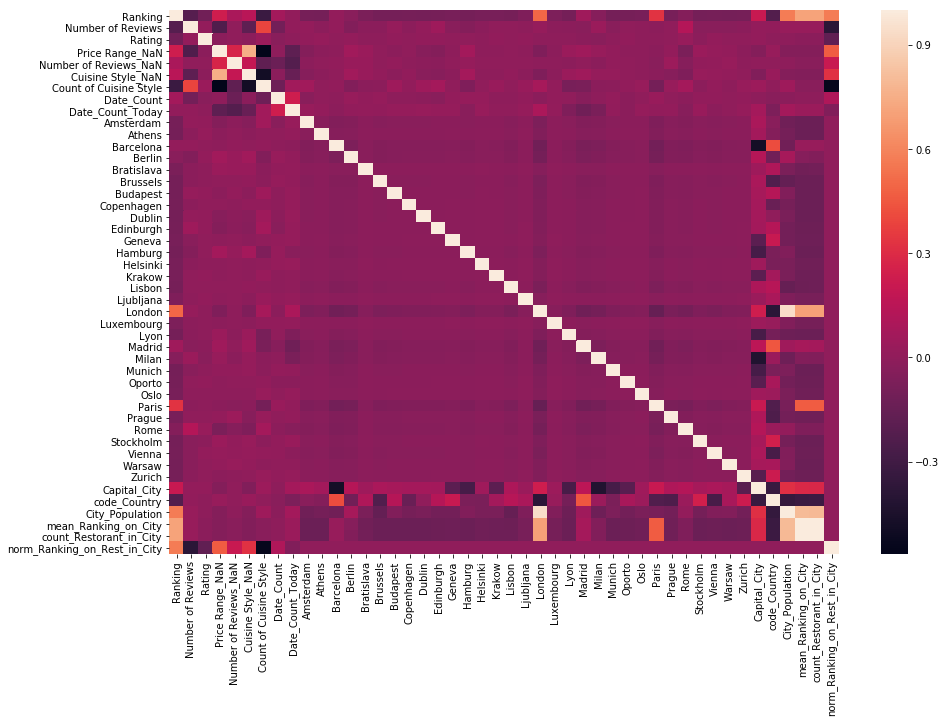

In [48]:
plt.rcParams['figure.figsize'] = (15,10)
listhead=[]
for i in Counter(kitchen).keys():
    listhead.append(i)
listhead.append('sample')
sns.heatmap(data.drop(listhead,axis=1).corr(),)

# Data Preprocessing

In [49]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [50]:
data.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating'],
      dtype='object')

In [51]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # ################### 2. NAN ##############################################################
    df_output['info from url']=df_output['URL_TA'].apply(lambda x:x.split('-')[1][1:])
    df_output['Number of Reviews_NaN']=pd.isna(df_output['Number of Reviews']).astype('uint8')
    df_output['Number of Reviews']=df_output['Number of Reviews'].fillna(df_output['Number of Reviews'].mean())
    
    price_range={'$':1,
            '$$ - $$$':2,
            '$$$$':3}
    #Избавимся от пропусков в колонке:
    df_output['Price Range_NaN']=pd.isna(df_output['Price Range']).astype('uint8')
    maxindex=0
    for index,i in enumerate(df_output['Price Range'].value_counts()):
        if i == df_output['Price Range'].value_counts().max():
            maxindex=df_output['Price Range'].value_counts().index[index]
    #print(maxindex)
    df_output['Price Range']=df_output['Price Range'].fillna(maxindex)
    print(df_output['Price Range'].value_counts())
    for ind,j in enumerate(df_output['Price Range']):
        df_output['Price Range'][ind]=price_range[j]
    #Заменяем пропуски на  часто встречающуюся кухню
    df_output['Cuisine Style_NaN']=pd.isna(df_output['Cuisine Style']).astype('uint8')
    for inde,info in enumerate(df_output['Cuisine Style'].isnull()):
        if info==True:
            df_output['Cuisine Style'].iloc[inde]=maxcount
    #Добавим колонку с количеством кухонь в ресторане
    df_output['Count of Cuisine Style']=kitchen_count
    # ################### 3. Encoding ######################################################
    ######## 
    for i in Counter(kitchen).keys():
        if i in df_output.columns:
            continue
        else:
            df_output[i]=0
    from sklearn.preprocessing import PolynomialFeatures
    df_output=pd.merge(df_output, pd.get_dummies(df_output.City), left_index=True, right_index=True)
    df_output['ID']=df_output['ID_TA'].apply(lambda x:x[1:])
    # ################### 4. Feature Engineering ####################################################
    list_NotCapitalCity = ['Barcelona', 'Milan', 'Hamburg', 'Munich', 
                          'Lyon', 'Zurich', 'Oporto', 'Geneva', 'Krakow']
    df_output['Capital_City'] = df_output['City'].apply(lambda x: 0 if x in list_NotCapitalCity else 1)
    
    dict_Сountries = {'London' : 'England', 'Paris' : 'France', 'Madrid' : 'Spain', 
                  'Barcelona' : 'Spain', 'Berlin' : 'Germany', 'Milan' : 'Italy', 
                  'Rome' : 'Italy', 'Prague' : 'Czech_c', 'Lisbon' : 'Portugal', 
                  'Vienna' : 'Austria', 'Amsterdam' : 'Holland', 
                  'Brussels' : 'Belgium', 'Hamburg' : 'Germany', 'Munich' : 'Germany', 
                  'Lyon' : 'France', 'Stockholm' : 'Sweden', 'Budapest' : 'Romania', 
                  'Warsaw' : 'Poland', 'Dublin' : 'Ireland', 'Copenhagen' : 'Denmark', 
                  'Athens' : 'Greece', 'Edinburgh' : 'Scotland', 'Zurich' : 'Switzerland', 
                  'Oporto' : 'Portugal', 'Geneva' : 'Switzerland', 'Krakow' : 'Poland', 
                  'Oslo' : 'Norway', 'Helsinki' : 'Finland', 'Bratislava' : 'Slovakia', 
                  'Luxembourg' : 'Luxembourg_c', 'Ljubljana' : 'Slovenia'}
    df_output['Сountry'] = df_output.apply(lambda row: dict_Сountries[row['City']], axis = 1)
    lb = LabelEncoder()
    lb.fit(df_output['Сountry'])
    df_output['code_Сountry'] = lb.transform(df_output['Сountry'])
    
    City_population={'London':8908081,
                'Paris':2148327,
                'Madrid':3266126,
                'Barcelona':1636762,
                'Berlin':3644826,
                 'Milan':1366180,
                 'Rome':2870500, 
                 'Prague':1324277,
                 'Lisbon':506654,
                 'Vienna':1897491,
                 'Amsterdam':860124,
                 'Brussels':185103,
                 'Hamburg':1841179,
                 'Munich':1571508,
                 'Lyon':516092,   
                 'Stockholm':975904,
                 'Budapest':1752286,
                 'Warsaw':1790658,
                 'Dublin':1173179,
                 'Copenhagen':794128,
                 'Athens':664046,  
                 'Edinburgh':513210,
                 'Zurich':434008, 
                 'Oporto':237591,  
                 'Geneva':201818,  
                 'Krakow':779115,  
                 'Oslo':693494,    
                 'Helsinki':643272,
                 'Bratislava':437725,
                 'Luxembourg':626108,
                 'Ljubljana':284355}
    CP=[]
    for i in df_output['City']:
        CP.append(City_population[i])
    df_output['City_Population']=CP
    
    mean_Ranking_on_City = df_output.groupby(['City'])['Ranking'].mean()
    count_Restorant_in_City = df_output['City'].value_counts(ascending=False)
    df_output['mean_Ranking_on_City'] = df_output['City'].apply(lambda x: mean_Ranking_on_City[x])
    df_output['count_Restorant_in_City'] = df_output['City'].apply(lambda x: count_Restorant_in_City[x])
    df_output['norm_Ranking_on_Rest_in_City'] = (df_output['Ranking'] - df_output['mean_Ranking_on_City']) / df_output['count_Restorant_in_City']
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

In [52]:
df_preproc = preproc_data(data)
df_preproc.head(10)

$$ - $$$    40402
$            7816
$$$$         1782
Name: Price Range, dtype: int64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Ranking,Number of Reviews,sample,Rating,Number of Reviews_NaN,Price Range_NaN,Cuisine Style_NaN,Count of Cuisine Style,Bar,Pub,...,Stockholm,Vienna,Warsaw,Zurich,Capital_City,code_Сountry,City_Population,mean_Ranking_on_City,count_Restorant_in_City,norm_Ranking_on_Rest_in_City
0,12963.0,4.000000,0,0.0,0,0,0,2,0,0,...,0,0,0,0,1,6,2148327,6938.557138,6108,0.986320
1,106.0,97.000000,0,0.0,0,0,0,5,0,0,...,0,0,0,0,1,5,643272,564.231579,475,-0.964698
2,810.0,28.000000,0,0.0,0,0,0,1,0,0,...,0,0,0,0,1,17,513210,885.130201,745,-0.100846
3,1669.0,202.000000,0,0.0,0,0,0,5,0,0,...,0,0,0,0,1,4,8908081,8169.707354,7193,-0.903755
4,37.0,162.000000,0,0.0,0,0,0,6,0,0,...,0,0,0,0,1,18,437725,462.428947,380,-1.119550
5,5093.0,24.000000,0,0.0,0,0,0,3,0,0,...,0,0,0,0,1,6,2148327,6938.557138,6108,-0.302154
6,3704.0,2.000000,0,0.0,0,0,0,2,0,0,...,0,0,0,0,1,15,506654,1867.330298,1647,1.115161
7,2330.0,124.471197,0,0.0,1,1,1,1,0,0,...,0,0,0,0,1,16,1752286,1219.061704,1021,1.088088
8,771.0,2.000000,0,0.0,0,1,0,2,0,0,...,0,0,0,0,1,5,643272,564.231579,475,0.435302
9,605.0,13.000000,0,0.0,0,1,0,1,0,0,...,1,0,0,0,1,21,975904,1237.482091,1033,-0.612277


In [53]:
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [54]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [55]:
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 170), (40000, 170), (40000, 169), (32000, 169), (8000, 169))

# Model 
Сам ML

In [56]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [57]:
RANDOM_SEED = 10

In [58]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [59]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [60]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.208910625


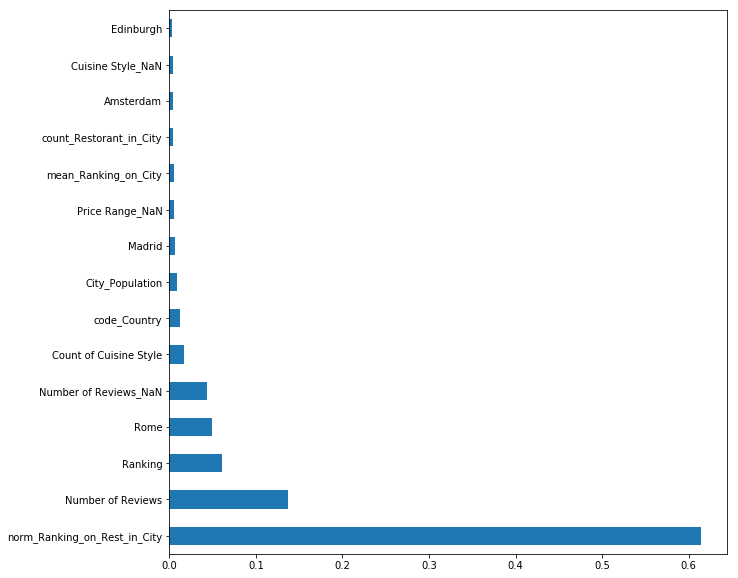

In [61]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission


In [62]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,Number of Reviews_NaN,Price Range_NaN,Cuisine Style_NaN,Count of Cuisine Style,Bar,Pub,European,...,Stockholm,Vienna,Warsaw,Zurich,Capital_City,code_Сountry,City_Population,mean_Ranking_on_City,count_Restorant_in_City,norm_Ranking_on_Rest_in_City
2866,4228.0,3.0,0.0,0,1,1,1,0,0,0,...,0,0,0,0,0,20,1636762,3879.422680,3395,0.102674
6867,122.0,87.0,0.0,0,0,0,5,0,0,0,...,0,0,0,0,1,5,643272,564.231579,475,-0.931014
5262,2281.0,77.0,0.0,0,0,0,3,0,0,0,...,0,0,0,0,0,11,1366180,3106.027840,2694,-0.306246
7136,1054.0,321.0,0.0,0,0,0,5,0,0,0,...,0,0,0,0,1,16,1752286,1219.061704,1021,-0.161667
2140,321.0,267.0,0.0,0,0,0,4,0,0,0,...,0,0,0,0,1,6,2148327,6938.557138,6108,-1.083425
9792,2608.0,45.0,0.0,0,0,0,1,0,0,0,...,0,0,0,0,1,20,3266126,4388.516391,3813,-0.466959
6699,2129.0,9.0,0.0,0,0,0,2,0,0,0,...,0,0,0,0,1,20,3266126,4388.516391,3813,-0.592582
3490,7218.0,113.0,0.0,0,0,0,2,0,0,0,...,0,0,0,0,1,6,2148327,6938.557138,6108,0.045750
201,725.0,263.0,0.0,0,0,0,8,0,0,0,...,0,0,0,0,1,4,8908081,8169.707354,7193,-1.034993
9143,7076.0,5.0,0.0,0,1,0,1,0,0,0,...,0,0,0,0,0,20,1636762,3879.422680,3395,0.941554


In [63]:
test_data = test_data.drop(['Rating'], axis=1)

In [64]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [65]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [66]:
predict_submission

array([3.135, 4.265, 4.605, ..., 3.01 , 4.315, 4.22 ])

In [67]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.135
1,id_1,4.265
2,id_2,4.605
3,id_3,4.180
4,id_4,4.485
5,id_5,4.305
6,id_6,1.545
7,id_7,3.120
8,id_8,4.220
9,id_9,4.610
